<a href="https://colab.research.google.com/github/sayem-eee-kuet/CausalModeling/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip3 install pyro-ppl

     |████████████████████████████████| 678 kB 7.1 MB/s 


In [4]:
import torch
print(torch.__version__)
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torchvision import datasets, transforms
import pyro
from pyro.nn import pyro_method
import pyro.distributions as dist
import pyro.distributions.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
smoke_test = ('CI' in os.environ)


import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, EmpiricalMarginal
from pyro.optim import Adam, SGD
import torch.distributions.constraints as constraints

1.10.0+cu111


In [5]:
from pyro.distributions import (
    Bernoulli, Beta, Gamma, Independent, MultivariateNormal,
    Normal, TorchDistribution, LowRankMultivariateNormal
)

In [ ]:
# import tensorflow as tf
# tf.test.gpu_device_name()

# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

In [ ]:
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# print(list(GPUs))
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[:]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm

In [7]:
USE_CUDA = True

## Data Loading

In [8]:
datapath = '/content/drive/MyDrive/Colab Notebooks/CausalVAE/datasets/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
# datapath = '/media/sayem/Drive_2/Code/datasets/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
dataset_zip = np.load(datapath,
                      encoding = 'bytes', 
                      allow_pickle=True
                      )
                      
for i, name in enumerate(dataset_zip.keys()):
    print(name, type(name))

# imgs = dataset_zip['imgs']
# print(igms.shape)
# labels = dataset_zip['latents_classes']
# label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
# label_names = dataset_zip['metadata'][()][b'latents_names']

metadata <class 'str'>
imgs <class 'str'>
latents_classes <class 'str'>
latents_values <class 'str'>


In [9]:
imgs = dataset_zip['imgs']
print(imgs.shape)
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

(737280, 64, 64)


In [10]:
indices_sampled = np.arange(imgs.shape[0])
print(indices_sampled)
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
print(imgs_sampled.shape)
labels_sampled = labels[indices_sampled]

[     0      1      2 ... 737277 737278 737279]
(737280, 64, 64)


In [11]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size, use_cuda=USE_CUDA):
	train_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 1, 64, 64),
	  torch.from_numpy(train_y.astype(np.float32))
	)
	test_dset = torch.utils.data.TensorDataset(
	  torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 1, 64, 64),
	  torch.from_numpy(test_y.astype(np.float32))
	)    
	kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
	
	train_loader = torch.utils.data.DataLoader(
	  dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
	)

	test_loader = torch.utils.data.DataLoader(
	  dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
	)
	return {"train":train_loader, "test":test_loader}

In [ ]:
# indices_sampled = np.arange(imgs.shape[0])
# print(indices_sampled)
# np.random.shuffle(indices_sampled)
# imgs_sampled = imgs[indices_sampled]
# print(imgs_sampled.shape)
# labels_sampled = labels[indices_sampled]

In [12]:
data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=128,
    use_cuda=USE_CUDA
)

In [ ]:
# # Traning Image
# data_itr = iter(data_loaders['train'])
# imgs, lbls = next(data_itr)
# print(imgs.shape)
# print(lbls.shape)

In [ ]:
# y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
# y_shapes = np.array((3, 6, 40, 32, 32))
# img_dict = {}

# for i, img in enumerate(imgs_sampled):
#      img_dict[tuple(labels_sampled[i])] = img
     
# zeros = np.array((3, 6, 40, 32, 32))
# img_dict[tuple(0, 0, 0, 0, 0, 0)] = np.zeros(64*64).reshape(64, 64)

# print(img_dict.keys())

# def find_in_dataset(shape, scale, orient, posX, posY):
#   fig = plt.figure()
#   img = img_dict[(0, shape, scale, orient, posX, posY)]
#   plt.imshow(img.reshape(64, 64), cmap='Greys_r', interpolation='nearest')
#   plt.axis('off')

# interact(find_in_dataset, 
#          shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
#          scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
#          orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
#          posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
#          posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

In [ ]:
# img = img_dict[(0, 1, 2, 25, 11, 23)]
# print(img.shape)
# plt.imshow(img, cmap='gray')

In [13]:
# class Encoder(nn.Module):
#     def __init__(self, hidden_dim: int):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         # self.h1_nchan = 64
#         # self.conv1 = nn.Sequential(
#         #     nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
#         #     nn.LeakyReLU(.1, inplace=True)
#         # )
#         # self.h2_nchan = 128
#         # self.conv2 = nn.Sequential(
#         #     nn.Conv2d(self.h1_nchan, self.h2_nchan, kernel_size=4, stride=2, padding=1),
#         #     nn.BatchNorm2d(self.h2_nchan),
#         #     nn.LeakyReLU(.1, inplace=True)
#         # )
#         # # print(*self.conv2)
        
#         # self.h3_nchan = 256
#         # self.conv3 = nn.Sequential(
#         #     nn.Conv2d(self.h2_nchan, self.h3_nchan, kernel_size=4, stride=2, padding=1),
#         #     nn.BatchNorm2d(self.h3_nchan),
#         #     nn.LeakyReLU(.1, inplace=True)
#         # )

#         # self.h4_dim = hidden_dim
#         self.fc1 = nn.Sequential(
#             nn.Linear(self.hidden_dim, 1000),
#             nn.BatchNorm1d(1000),
#             nn.LeakyReLU(0.1, inplace=True)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1000, 1000),
#             nn.BatchNorm1d(1000),
#             nn.LeakyReLU(0.1, inplace=True)
#         )
#         self.fc_mu = nn.Sequential(
#             nn.Linear(1000, self.hidden_dim),
#             nn.BatchNorm1d(self.hidden_dim),
#             nn.LeakyReLU(0.1, inplace=True)
#         )

#         self.fc_sigma = nn.Sequential(
#             nn.Linear(1000, self.hidden_dim),
#             nn.BatchNorm1d(self.hidden_dim),
#             nn.LeakyReLU(0.1, inplace=True)
#         )

#     def forward(self, x):
#         # print("x shape", x.shape)
#         # x = self.conv1(x)
#         # # print(x.shape)
#         # x = self.conv2(x)
#         # # print(x.shape)
#         # x = self.conv3(x)
#         # # print(x.shape)
#         # x = x.view(-1, 8 * 8 * self.h3_nchan)
#         # print(x.shape)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         z_mu = self.fc_mu(x)
#         z_sigma = torch.exp(self.fc_sigma(x))
#         return z_mu, z_sigma


class Encoder(nn.Module):
    def __init__(self, hidden_dim: int):
        super().__init__()
        self.h1_nchan = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(.1, inplace=True)
        )
        self.h2_nchan = 128
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.h1_nchan, self.h2_nchan, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.h2_nchan),
            nn.LeakyReLU(.1, inplace=True)
        )
        # print(*self.conv2)
        
        self.h3_nchan = 256
        self.conv3 = nn.Sequential(
            nn.Conv2d(self.h2_nchan, self.h3_nchan, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.h3_nchan),
            nn.LeakyReLU(.1, inplace=True)
        )

        self.h4_dim = hidden_dim

        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * self.h3_nchan, self.h4_dim),
            nn.BatchNorm1d(self.h4_dim),
            nn.LeakyReLU(.1, inplace=True)
        )

        # self.fc_sigma = nn.Sequential(
        # nn.Linear(8 * 8 * self.h3_nchan, self.h4_dim),
        # nn.BatchNorm1d(self.h4_dim),
        # nn.LeakyReLU(.1, inplace=True)
        # )

    def forward(self, x):
        # print("x shape", x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = x.view(-1, 8 * 8 * self.h3_nchan)
        # print(x.shape)
        # z_mu = self.fc_mu(x)
        # z_sigma = torch.exp(self.fc_sigma(x))
        x = self.fc(x)
        return x



class Decoder(nn.Module):
    def __init__(self, latent_dim: int, upconv = False):
        super().__init__()
        self.laten_dim = latent_dim
        self.h1_dim = 256
        self.fc1 = nn.Sequential(
            nn.Linear(self.laten_dim, self.h1_dim),
            nn.BatchNorm1d(self.h1_dim),
            nn.ReLU(inplace=True)
        )
        self.h2_nchan = 128
        h2_dim = 8 * 8 * self.h2_nchan
        self.fc2 = nn.Sequential(
            nn.Linear(self.h1_dim, h2_dim),
            nn.BatchNorm1d(h2_dim),
            nn.ReLU(inplace=True)
        )
        self.h3_nchan = 64
        self.h4_nchan = 32
        if upconv:
            conv1_ops = [
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(self.h2_nchan, self.h3_nchan, kernel_size=5, stride=1, padding=2)
            ]
            conv2_ops = [
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(self.h3_nchan, 1, kernel_size=5, stride=1, padding=2)
            ]
        else:
            conv1_ops = [nn.ConvTranspose2d(self.h2_nchan, self.h3_nchan,
                                            kernel_size=4, stride=2, padding=1)]

            conv2_ops = [nn.ConvTranspose2d(self.h3_nchan, self.h4_nchan, kernel_size=4, 
                                            stride=2, padding=1)]

            conv3_ops = [nn.ConvTranspose2d(self.h4_nchan, 1, kernel_size=4, 
                                            stride=2, padding=1)]

        self.conv1 = nn.Sequential(
            *conv1_ops,
            nn.BatchNorm2d(self.h3_nchan),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(*conv2_ops)

        self.conv3 = nn.Sequential(*conv3_ops)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.fc1(x)
        # print("fc1: ", x.shape)
        x = self.fc2(x).view(-1, self.h2_nchan, 8, 8)
        # print("fc2: ", x.shape)
        x = self.conv1(x)
        # print("conv1: ", x.shape)
        x = self.conv2(x)
        # print("conv2: ", x.shape)
        x = self.conv3(x)
        # print("conv3: ", x.shape)
        x = self.sigmoid(x.flatten())
        # print("x shape form decoder", x.shape)
        return x

In [14]:
class DeepConditional(nn.Module):
    def predict(self, x: torch.Tensor) -> TorchDistribution:
        raise NotImplementedError


class _DeepIndepNormal(DeepConditional):
    def __init__(self, backbone: nn.Module, mean_head: nn.Module, logvar_head: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.mean_head = mean_head
        self.logvar_head = logvar_head

    def forward(self, x):
        h = self.backbone(x)
        mean = self.mean_head(h)
        logvar = self.logvar_head(h)
        return mean, logvar

    def predict(self, x) -> Independent:
        mean, logvar = self(x)
        std = (.5 * logvar).exp()
        event_ndim = len(mean.shape[1:])  # keep only batch dimension
        return mean, std, Normal(mean, std).to_event(event_ndim)


class DeepIndepNormal(_DeepIndepNormal):
    def __init__(self, backbone: nn.Module, hidden_dim: int, out_dim: int):
        super().__init__(
            backbone=backbone,
            mean_head=nn.Linear(hidden_dim, out_dim),
            logvar_head=nn.Linear(hidden_dim, out_dim)
        )


In [36]:
class CVAE(nn.Module):
    def __init__(self, hidden_dim: int, config_enum=None, use_cuda=False, aux_loss_multiplier=None) -> None:
        super(CVAE, self).__init__()
        self.hidden_dim = hidden_dim
        self.label_shape = np.array((1, 3, 6, 40, 32, 32))
        self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
        self.label_dim = np.sum(self.label_shape)  # one-hot encoded vectors of the labels

        # self.register_buffer('z_loc', torch.zeros([hidden_dim, ], requires_grad=False))
        # self.register_buffer('z_scale', torch.ones([hidden_dim, ], requires_grad=False))
        self.z_dim = 64 * 64 # self.hidden_dim + self.label_dim
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        self.setup_network()

        # if use_cuda:
        #   self.cuda()

        # self.use_cuda = use_cuda
    
    def setup_network(self):
        self.encoder = Encoder(self.hidden_dim)
        # self.encoder_hidden = Encoder_hidden(self.hidden_dim)

        latent_layers = torch.nn.Sequential(torch.nn.Linear(self.hidden_dim + self.label_dim, 
                                            self.z_dim), 
                                            torch.nn.ReLU())
        self.latent_encoder = DeepIndepNormal(latent_layers, self.z_dim, 
                                             self.z_dim)

        self.decoder = Decoder(self.hidden_dim + self.label_dim)

        if self.use_cuda:
          self.cuda()

    def pgm(self, ys):
        new_ys = []
        options = dict(dtype=ys.dtype, device=ys.device)
        for i, label_length in enumerate(self.label_shape):
            prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
            new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
                                    obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
            # print(new_ys)
            # break
        new_ys = torch.cat(new_ys, -1)
        new_ys = new_ys.to(torch.float32)
        # print(new_ys.shape)
        return new_ys


    def model(self, xs, ys):
        pyro.module("cvae", self)
        batch_size = xs.size(0)
        # print(batch_size)
        # print(self.z_dim)
        options = dict(dtype=xs.dtype, device=xs.device)
        # print(options)
        with pyro.plate("data", batch_size):
            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample('z', dist.Normal(prior_loc, prior_scale).to_event(1))
            # print("zs shape: ", zs.shape)
            y_new = self.pgm(ys)
            zs = torch.cat([zs, y_new], 1)
            loc = self.decoder.forward(zs)
            # print("loc shape: ", loc.shape)
            # print("xs from model: ", xs.shape)
            x = pyro.sample('x', dist.Bernoulli(loc).to_event(1), obs=xs.flatten())
            # print(x.shape)
            # print("before return---")
            return loc
            
    def guide(self, xs, ys):
        # print(xs.shape)
        pyro.module("cvae", self)
        batch_size = xs.size(0)
        with pyro.plate("data", batch_size):
            # print(xs.shape)
            # hidden = self.encoder_hidden.forward(xs)
            hidden = self.encoder.forward(xs)
            # print("Hidden before: ", hidden.shape)
            y_new = self.pgm(ys)
            hidden = torch.cat([hidden, y_new], 1)
            # print("Hidden after:", hidden)
            # distribution q(z|x) = normal(loc(x),scale(x))
            # print("After: ys + hidden: ", hidden.shape)
            mu, sigma, latent_dist = self.latent_encoder.predict(hidden)
            # print("from guide: ", mu.shape)
            # print("from guide: ", sigma.shape)

            # loc, scale = self.encoder.forward(hidden)

            # print(type(latent_dist))

            z = pyro.sample('z', latent_dist)
            # z = pyro.sample("z", dist.Normal(loc, scale).to_event(1))
            # print("z_shape:", z.shape)
        return mu, sigma, z 
    
    def reconst_image(self, xs, ys):
            hidden = self.encoder.forward(xs)
            print("hidden shape", hidden.shape)
            y_new = self.pgm(ys)
            hidden = torch.cat([hidden, y_new], -1)
            print(hidden.shape)
            # distribution q(z|x) = normal(loc(x),scale(x))
            # print(hidden.shape)
            _, _, latent_dist = self.latent_encoder.predict(hidden)
            print(latent_dist)
            zs = pyro.sample('z', latent_dist)
            zs = torch.cat([zs, y_new], -1)
            print(zs.shape)
            loc = self.decoder.forward(zs)
            return dist.Bernoulli(loc).to_event(1).sample()

In [37]:
def train(svi, train_loader, use_cuda=False):
	# initialize loss accumulator
	epoch_loss = 0.
	# do a training epoch over each mini-batch x returned
	# by the data loader
	for xs,ys in train_loader:
	 # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	 # do ELBO gradient and accumulate loss
	  epoch_loss += svi.step(xs, ys)
	# return epoch loss
	normalizer_train = len(train_loader.dataset)
	total_epoch_loss_train = epoch_loss / normalizer_train
	return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
	# initialize loss accumulator
	test_loss = 0.
	# compute the loss over the entire test set
	for xs, ys in test_loader:
	  # if on GPU put mini-batch into CUDA memory
	  if use_cuda:
	      xs = xs.cuda()
	      ys = ys.cuda()
	  # compute ELBO estimate and accumulate loss
	  test_loss += svi.evaluate_loss(xs, ys)
	normalizer_test = len(test_loader.dataset)
	total_epoch_loss_test = test_loss / normalizer_test
	return total_epoch_loss_test

In [38]:
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 10
TEST_FREQUENCY = 5

In [39]:

import warnings
warnings.filterwarnings('ignore')

# clear param store
pyro.clear_param_store()

USE_CUDA = True
hidden_dim = 64*64
# setup the VAE
vae = CVAE(hidden_dim, use_cuda=USE_CUDA)

In [ ]:

# import warnings
# warnings.filterwarnings('ignore')

# # clear param store
# pyro.clear_param_store()

# USE_CUDA = True
# hidden_dim = 64*64
# # setup the VAE
# vae = CVAE(hidden_dim, use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store

pyro.clear_param_store()

# network_path = '/media/sayem/Drive_2/Code/trainedModel/trained_model.save'
network_path = '/content/drive/MyDrive/Colab Notebooks/CausalVAE/trained_model.save'
# network_path = "/content/gdrive/My Drive/causalvae/trained_model.save"
""
#PATH = "/content/gdrive/My Drive/causalvae/trained_model.save"

# new model
# vae = CVAE(use_cuda=USE_CUDA)

# save current model


# to load params from trained model
# vae = CVAE(use_cuda=USE_CUDA)
torch.save(vae.state_dict(), network_path)
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

In [19]:
network_path = '/content/drive/MyDrive/Colab Notebooks/CausalVAE/trained_model.save'
vae.load_state_dict(torch.load(network_path))

<All keys matched successfully>

In [20]:
import warnings
warnings.filterwarnings("ignore")

data_iter = iter(data_loaders["test"])
xs, ys = next(data_iter)

# vae.load_state_dict(torch.load(network_path))
# vae = CVAE(hidden_dim, use_cuda=USE_CUDA)

if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()
# vae.eval()
    
rs = vae.reconst_image(xs, ys)
if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()

originals = xs.numpy().reshape(-1, 64, 64)
recons = rs.reshape(-1, 64, 64)

hidden shape torch.Size([128, 4096])
torch.Size([128, 4210])
Independent(Normal(loc: torch.Size([128, 4096]), scale: torch.Size([128, 4096])), 1)
torch.Size([128, 4210])


In [21]:
print(recons.shape)

torch.Size([128, 64, 64])


In [22]:

# [ 0,  2,  1, 34,  4, 24]
def recon_check(original, recon):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original, cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon , cmap='Greys_r', interpolation='nearest')
    plt.axis('off')

def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0], step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=128), Output()), _dom_classes=('widget-interact'…

<function __main__.f>

In [33]:
# print(imgs_sampled[:1000].shape)
# print(data_loaders['test'])

In [34]:
y_names = ['shape', 'scale', 'orientation', 'posX', 'posY']
y_shapes = np.array((3, 6, 40, 32, 32))
img_dict = {}

# data_loaders['train']

for i, img in enumerate(imgs_sampled):
     img_dict[tuple(labels_sampled[i])] = img

def find_in_dataset(shape, scale, orient, posX, posY):
    fig = plt.figure()
    img = img_dict[(0, shape, scale, orient, posX, posY)]
    plt.imshow(img.reshape(64,64), cmap='Greys_r', interpolation='nearest')
    plt.axis('off')

interact(find_in_dataset, 
         shape=widgets.IntSlider(min=0, max=2, step=1, value=0),
         scale=widgets.IntSlider(min=0, max=5, step=1, value=0),
         orient=widgets.IntSlider(min=0, max=39, step=1, value=0),
         posX=widgets.IntSlider(min=0, max=31, step=1, value=0),
         posY=widgets.IntSlider(min=0, max=31, step=1, value=0))

interactive(children=(IntSlider(value=0, description='shape', max=2), IntSlider(value=0, description='scale', …

<function __main__.find_in_dataset>

<Figure size 432x288 with 0 Axes>

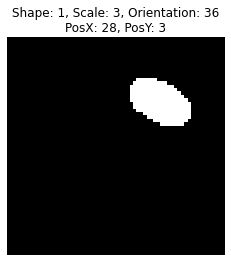

In [35]:

def get_specific_data(args=dict(), cuda=False):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        cuda - bool to indicate whether the output should be placed on GPU
    '''
    names_dict = {'shape': 1, 'scale': 2, 'orientation': 3, 'posX': 4, 'posY': 5}
    selected_ind = np.ones(imgs.shape[0], dtype=bool)
    for k,v in args.items():
        col_id = names_dict[k]
        selected_ind = np.bitwise_and(selected_ind, labels[:, col_id] == v)
    ind = np.random.choice(np.arange(imgs.shape[0])[selected_ind])
    x = torch.from_numpy(imgs[ind].reshape(1,64**2).astype(np.float32))
    y = torch.from_numpy(labels[ind].reshape(1,6).astype(np.float32))
    if not cuda:
        return x,y
    x = x.cuda()
    y = y.cuda()
    return x,y

def plot_image(x):
    """
    helper to plot dSprites images
    """
    x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

def see_specific_image(args=dict(), verbose=True):
    '''
    use this function to get examples of data with specific class labels
    inputs: 
        args - dictionary whose keys can include {shape, scale, orientation,
                posX, posY} and values can include any integers less than the 
                corresponding size of that label dimension
        verbose - bool to indicate whether the full class label should be written 
                    as the title of the plot
    '''
    x,y = get_specific_data(args, cuda=False)
    plot_image(x)
    if verbose:
        string = ''
        for i, s in enumerate(['Shape', 'Scale', 'Orientation', 'PosX', 'PosY']):
            string += '%s: %d, ' % (s, int(y[0][i+1]))
            if i == 2:
                string = string[:-2] + '\n'
        plt.title(string[:-2], fontsize=12)
        
def compare_reconstruction(original, recon):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array for recon image
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(recon.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstruction')
    
def compare_to_density(original, recons):
    """
    compare two images side by side
    inputs:
        original - array for original image
        recon - array of multiple recon images
    """
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(original.cpu().reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('original')
    ax1 = fig.add_subplot(122)
    plt.imshow(torch.mean(recons.cpu(), 0).reshape(64,64), cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    plt.title('reconstructions')

        
see_specific_image()

# compare_to_density(torch.from_numpy(originals[0]),recons[0])

In [ ]:
# import torch
# import torch.nn as nn

# print(type(originals[0]))

# original = torch.from_numpy(originals[1])
# recon = recons[1]

# mse_loss = nn.MSELoss()
# output = mse_loss(original, recon)
# # output.backward()

# print(output)

# err = original - recon
# print(err.shape)
# plt.imshow(err, cmap='hsv',  interpolation='nearest')
# plt.colorbar(cmap='hsv')

# SCM

In [ ]:
data_iter = iter(data_loaders["test"])
xs, ys = next(data_iter)
ys.device

device(type='cpu')

In [ ]:
label_shape = np.array((1, 3, 6, 40, 32, 32))
label_dims = vae.label_shape
print(label_dims)


[ 1  3  6 40 32 32]


In [ ]:
class SCM():
    def __init__(self, vae, mu, sigma) -> None:
        self.vae = vae
        self.mu = mu
        self.sigma = sigma
        self.z_dim = vae.z_dim
        # print(self.z_dim)
        self.label_dims = vae.label_shape
        self.image_dim = 64**2

        self.init_noise = {
        'N_X'   : dist.Normal(torch.zeros(self.image_dim), torch.ones(self.image_dim)),
        'N_Z'   : dist.Normal(torch.zeros(self.z_dim), torch.ones(self.z_dim)),
        'N_Y_1' : dist.Uniform(torch.zeros(self.label_dims[1]),torch.ones(self.label_dims[1])),
        'N_Y_2' : dist.Uniform(torch.zeros(self.label_dims[2]),torch.ones(self.label_dims[2])),
        'N_Y_3' : dist.Uniform(torch.zeros(self.label_dims[3]),torch.ones(self.label_dims[3])),
        'N_Y_4' : dist.Uniform(torch.zeros(self.label_dims[4]),torch.ones(self.label_dims[4])),
        'N_Y_5' : dist.Uniform(torch.zeros(self.label_dims[5]),torch.ones(self.label_dims[5]))            
        }

    def f_Z(self, N):

        """
        z ~ Normal(mu, sigma)
        """
        # print("mu shape from f_Z:", mu.shape)
        # print("sigma shape from f_Z:", sigma.shape)
        # print("N shape:", N.shape)
        return N * self.sigma + self.mu
    
    def f_Y(self, N):
      # print("N shape from f_Y: ", N.shape)
      # latent_layers = torch.nn.Sequential(torch.nn.Linear(N.size(0), N.size(0)), 
      #                                     torch.nn.ReLU())
      # latent_encoder = DeepIndepNormal(latent_layers, N.size(0), N.size(0))
      # mu, sigma, distribution = latent_encoder.predict(N)
      # return mu, sigma, distribution
      beta = 12
      indices = torch.tensor(np.arange(N.size(0))).to(torch.float32)
      smax = nn.functional.softmax(beta*N)
      argmax_ind = torch.sum(smax*indices)
      return argmax_ind

    def f_X(self, Y, Z, N):
      zs = Z.cuda()
      # print("zs shape form f_X:", zs.shape)
      # convert the labels to one hot
      ys = [torch.tensor([0])]
      ys.append(torch.nn.functional.one_hot(torch.round(Y[0]).to(torch.long), int(self.label_dims[1])))
      ys.append(torch.nn.functional.one_hot(torch.round(Y[1]).to(torch.long), int(self.label_dims[2])))
      ys.append(torch.nn.functional.one_hot(torch.round(Y[2]).to(torch.long), int(self.label_dims[3])))
      ys.append(torch.nn.functional.one_hot(torch.round(Y[3]).to(torch.long), int(self.label_dims[4])))
      ys.append(torch.nn.functional.one_hot(torch.round(Y[4]).to(torch.long), int(self.label_dims[5])))
      ys = torch.cat(ys).to(torch.float32).reshape(1, -1).cuda()
      # print(ys.shape)
      hidden = torch.cat([zs, ys], 1)
      # print("hidden shape:", hidden.shape)
      x = vae.decoder.forward(hidden)
      return (N < x.cpu()).type(torch.float)

    def model(self, noise):
      N_X = pyro.sample( 'N_X', noise['N_X'].to_event(1) ) #, constraint=constraints.positive)
      # denoted using the index in the sequence 
      # that they are stored in as vae.label_names:
      # ['shape', 'scale', 'orientation', 'posX', 'posY']
      N_Y_1 = pyro.sample( 'N_Y_1', noise['N_Y_1'].to_event(1) ) #, constraint=constraints.positive)
      # print(N_Y_1)
      N_Y_2 = pyro.sample( 'N_Y_2', noise['N_Y_2'].to_event(1) ) #, constraint=constraints.positive)
      N_Y_3 = pyro.sample( 'N_Y_3', noise['N_Y_3'].to_event(1) ) #, constraint=constraints.positive)
      N_Y_4 = pyro.sample( 'N_Y_4', noise['N_Y_4'].to_event(1) ) #, constraint=constraints.positive)
      N_Y_5 = pyro.sample( 'N_Y_5', noise['N_Y_5'].to_event(1) ) #, constraint=constraints.positive)

      N_Z = pyro.sample( 'N_Z', noise['N_Z'].to_event(1))
      # print(N_Z)
      Z = pyro.sample('Z', dist.Normal( self.f_Z(N_Z), 1e-1).to_event(1))
      # print("Z shape from model:", Z.shape)

      # _, _, dist_1 = self.f_Y(N_Y_1)
      # # print(dist_1)
      # Y_1 = pyro.sample('Y_1', dist_1.to_event(1))
      # print("Y_1 sample :", Y_1)
      # _, _, dist_2 = self.f_Y(N_Y_2)
      # Y_2 = pyro.sample('Y_2', dist_2.to_event(1))
      # _, _, dist_3 = self.f_Y(N_Y_3)
      # Y_3 = pyro.sample('Y_3', dist_3.to_event(1))
      # _, _, dist_4 = self.f_Y(N_Y_4)
      # Y_4 = pyro.sample('Y_4', dist_4.to_event(1))
      # _, _, dist_5 = self.f_Y(N_Y_5)
      # Y_5 = pyro.sample('Y_5', dist_5.to_event(1))

      Y_1 = pyro.sample('Y_1', dist.Normal( self.f_Y(N_Y_1), 1e-1) )
      Y_2 = pyro.sample('Y_2', dist.Normal( self.f_Y(N_Y_2), 1e-1) )
      Y_3 = pyro.sample('Y_3', dist.Normal( self.f_Y(N_Y_3), 1e-1) )
      Y_4 = pyro.sample('Y_4', dist.Normal( self.f_Y(N_Y_4), 1e-1) )
      Y_5 = pyro.sample('Y_5', dist.Normal( self.f_Y(N_Y_5), 1e-1) )

      X = pyro.sample('X', dist.Normal(self.f_X( (Y_1, Y_2, Y_3, Y_4, Y_5), Z, N_X), 1e-2).to_event(1))

      # return noise and variables
      noise_samples = N_X, (N_Y_1, N_Y_2, N_Y_3, N_Y_4, N_Y_5), N_Z
      variable_samples = X, (Y_1, Y_2, Y_3, Y_4, Y_5), Z
      return variable_samples, noise_samples

    def guide(self, noise):
      """
      The guide serves as an approximation to the posterior p(z|x). 
      The guide provides a valid joint probability density over all the 
      latent random variables in the model.
      
      https://pyro.ai/examples/svi_part_i.html
      """
      # create params with constraints
      mu = {
          'N_X': pyro.param('N_X_mu', 0.5*torch.ones(self.image_dim), constraint = constraints.interval(0., 1.)),
          'N_Z': pyro.param('N_Z_mu', torch.zeros(self.z_dim), constraint = constraints.interval(-3., 3.)),
          'N_Y_1': pyro.param('N_Y_1_mu', 0.5*torch.ones(self.label_dims[1]), constraint = constraints.interval(0., 1.)),
          'N_Y_2': pyro.param('N_Y_2_mu', 0.5*torch.ones(self.label_dims[2]), constraint = constraints.interval(0., 1.)),
          'N_Y_3': pyro.param('N_Y_3_mu', 0.5*torch.ones(self.label_dims[3]), constraint = constraints.interval(0., 1.)),
          'N_Y_4': pyro.param('N_Y_4_mu', 0.5*torch.ones(self.label_dims[4]), constraint = constraints.interval(0., 1.)),
          'N_Y_5': pyro.param('N_Y_5_mu', 0.5*torch.ones(self.label_dims[5]), constraint = constraints.interval(0., 1.))
          }
      sigma = {
          'N_X': pyro.param('N_X_sigma', 0.1*torch.ones(self.image_dim), constraint = constraints.interval(0.0001, 0.5)),
          'N_Z': pyro.param('N_Z_sigma', torch.ones(self.z_dim), constraint = constraints.interval(0.0001, 3.)),
          'N_Y_1': pyro.param('N_Y_1_sigma', 0.1*torch.ones(self.label_dims[1]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_2': pyro.param('N_Y_2_sigma', 0.1*torch.ones(self.label_dims[2]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_3': pyro.param('N_Y_3_sigma', 0.1*torch.ones(self.label_dims[3]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_4': pyro.param('N_Y_4_sigma', 0.1*torch.ones(self.label_dims[4]), constraint = constraints.interval(0.0001, 0.5)),
          'N_Y_5': pyro.param('N_Y_5_sigma', 0.1*torch.ones(self.label_dims[5]), constraint = constraints.interval(0.0001, 0.5))
          }
      for noise_term in noise.keys():
          pyro.sample(noise_term, dist.Normal(mu[noise_term], sigma[noise_term]).to_event(1))

    def update_noise_svi(self, obs_data, intervened_model=None):
         # Condition the model
        if intervened_model is not None:
          obs_model = pyro.condition(intervened_model, obs_data)
        else:
          obs_model = pyro.condition(self.model, obs_data)
          
        pyro.clear_param_store()

        svi = SVI(
            model = obs_model,
            guide = self.guide,
            optim = SGD({"lr": 1e-5, "momentum": 0.1}),
            loss = Trace_ELBO(retain_graph=True)
        )

        num_steps = 1500
        samples = defaultdict(list)
        for t in range(num_steps):
            loss = svi.step(self.init_noise)
#             if t % 100 == 0:
#                 print("step %d: loss of %.2f" % (t, loss))
            for noise in self.init_noise.keys():
                mu = '{}_mu'.format(noise)
                sigma = '{}_sigma'.format(noise)
                samples[mu].append(pyro.param(mu).detach().numpy())
                samples[sigma].append(pyro.param(sigma).detach().numpy())
        means = {k: torch.tensor(np.array(v).mean(axis=0)) for k, v in samples.items()}
        
        # update the inferred noise
        updated_noise = {
            'N_X'  : dist.Normal(means['N_X_mu'], means['N_X_sigma']),
            'N_Z'  : dist.Normal(means['N_Z_mu'], means['N_Z_sigma']),
            'N_Y_1': dist.Normal(means['N_Y_1_mu'], means['N_Y_1_sigma']),
            'N_Y_2': dist.Normal(means['N_Y_2_mu'], means['N_Y_2_sigma']),
            'N_Y_3': dist.Normal(means['N_Y_3_mu'], means['N_Y_3_sigma']),
            'N_Y_4': dist.Normal(means['N_Y_4_mu'], means['N_Y_4_sigma']),
            'N_Y_5': dist.Normal(means['N_Y_5_mu'], means['N_Y_5_sigma']),
        }
        return updated_noise


In [ ]:
# Generate an instance of dSprites image 
ox, y = get_specific_data(cuda=True)
# plot_image(ox)
# print(ox.shape)
# print(y.shape)
ox = ox.reshape(-1, 1, 64, 64)
print(ox.dtype)
vae.eval()
mu, sigma, z = vae.guide(ox, y)
print(mu.shape)
print(sigma.shape)
print(z.shape)
scm = SCM(vae, mu.cpu(), sigma.cpu())

torch.float32
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])


In [ ]:
cond_data = {}
for i in range(1, 6):
    cond_data["Y_{}".format(i)] = torch.tensor(y[0,i].cpu()).to(torch.float32)
print(cond_data)

{'Y_1': tensor(2.), 'Y_2': tensor(0.), 'Y_3': tensor(4.), 'Y_4': tensor(25.), 'Y_5': tensor(31.)}


In [ ]:
# trace = pyro.poutine.trace(scm).get_trace()

# trace.compute_log_prob() # optional, but allows printing of log_prob shapes
# print(trace.format_shapes())

In [ ]:
conditioned_model = pyro.condition(scm.model, data=cond_data)
# trace = pyro.poutine.trace(conditioned_model)
cond_noise = scm.update_noise_svi(cond_data)
print(cond_noise['N_Y_1'])

ValueError: ignored

In [ ]:
print(type(cond_noise['N_Y_1']))

<class 'pyro.distributions.torch.Normal'>


In [ ]:
rxs = []
for i in range(100):
    (rx, ry,_), _ = scm.model(cond_noise)
    rxs.append(rx)
compare_to_density(ox, torch.cat(rxs))
_ =plt.suptitle("SCM Conditioned on Original", fontsize=18, fontstyle='italic')

tensor([0.3576, 0.3411, 0.5172])


RuntimeError: ignored

In [ ]:

# intervening on Shape, posX and PosY 
intervened_model = pyro.do(scm.model, data={
    "Y_1": torch.tensor(0.),
#     "Y_4": torch.tensor(5.),
#     "Y_5": torch.tensor(25.),
})
noise_data = {}
for term, d in cond_noise.items():
    noise_data[term] = d.loc
# intervened_noise = scm.update_noise_svi(noise_data, intervened_model)

In [ ]:
(rx1,ry,_), _ = intervened_model(scm.init_noise)
compare_to_density(ox, rx1)
print(ry)

RuntimeError: ignored